

In the dataset about the restaurant evaluations in NYC. There's about 15 variables. Here's the link:

https://nycopendata.socrata.com/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/xx67-kt59

* Current grade by type of cuisine
* A distribution of violation code, to see which violations are most popular

In [9]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [82]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
from scipy import stats
import numpy as np
from IPython.display import display, HTML
plt.style.use('ggplot')
%pylab inline
;

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


''

## Exploring the data set "EDA"

In [12]:
df = pd.read_csv('../data/DOHMH_New_York_City_Restaurant_Inspection_Results.csv')

In [13]:
df[:2]

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE
0,30075445,MORRIS PARK BAKE SHOP,BRONX,1007,MORRIS PARK AVE ...,10462,7188924968,Bakery,03/03/2014,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,Not Critical,2,A,03/03/2014,11/15/2014,Cycle Inspection / Initial Inspection
1,30075445,MORRIS PARK BAKE SHOP,BRONX,1007,MORRIS PARK AVE ...,10462,7188924968,Bakery,10/10/2013,No violations were recorded at the time of thi...,NaN,NaN,Not Applicable,NaN,NaN,NaN,11/15/2014,Trans Fat / Second Compliance Inspection


### What are some other stats we can take into consideration? How is the data distributed?

In [75]:
display(df.describe())

,CAMIS,ZIPCODE,SCORE
count,523967.000000,523965.000000,490100.000000
mean,41969457.460018,10661.922953,21.852934
std,2471428.753225,599.848347,14.892681
min,30075445.000000,7005.000000,-1.000000
25%,41024211.000000,10019.000000,12.000000
50%,41393597.000000,10465.000000,19.000000
75%,41611217.000000,11229.000000,27.000000
max,50017476.000000,11697.000000,156.000000


### What do the rows look like?

In [76]:
df[['GRADE','CUISINE DESCRIPTION' ,'DBA']][:10]

,GRADE,CUISINE DESCRIPTION,DBA
0,A,Bakery,MORRIS PARK BAKE SHOP
1,NaN,Bakery,MORRIS PARK BAKE SHOP
2,A,Bakery,MORRIS PARK BAKE SHOP
3,A,Bakery,MORRIS PARK BAKE SHOP
4,NaN,Bakery,MORRIS PARK BAKE SHOP
5,NaN,Bakery,MORRIS PARK BAKE SHOP
6,NaN,Bakery,MORRIS PARK BAKE SHOP
7,NaN,Bakery,MORRIS PARK BAKE SHOP
8,NaN,Bakery,MORRIS PARK BAKE SHOP
9,NaN,Bakery,MORRIS PARK BAKE SHOP


In [15]:
def df_to_perc_breakouts_per_cuisine(input_df):
    '''
    INPUT: DF with each restuarant and grade listed (Raw Data)
    OUTPUT: DF with percentage composition by cuisine type
    '''
    output_df = input_df[['CUISINE DESCRIPTION','GRADE']].groupby('CUISINE DESCRIPTION').count()
    
    #function used to normalize grades by percentage
    perc_computation_function = \
    lambda x: x[x['GRADE'] == str(letter)].count() / x['GRADE'].count()

    for letter in input_df['GRADE'].unique():
        temp_df = input_df.groupby('CUISINE DESCRIPTION')
        temp_df = temp_df.apply(perc_computation_function)
        output_df[str(letter)] = temp_df['GRADE']    
    return output_df

## Preprocess the data

In [16]:
# transforming the raw data the percentage versus counts
df_cuisine_grades_by_composition = df_to_perc_breakouts_per_cuisine(df)

del df_cuisine_grades_by_composition['GRADE']
del df_cuisine_grades_by_composition['nan']

# now we're ready to plot it
df_cuisine_grades_by_composition[:2] 

,A,B,Z,C,P,Not Yet Graded
CUISINE DESCRIPTION,,,,,,
Afghan,0.689655,0.155172,0.000000,0.112069,0.043103,0.000000
African,0.515957,0.268617,0.027926,0.156915,0.023936,0.006649


In [17]:
def plot_stacked_bar(df_to_plot, label, color_map = 'YlOrBr'):
    '''
    INPUT: DF, label(string) for the x-axis to be displayed at the top
    OUTPUT: Stacked Bar Chart
    '''
    # create a figure of given size
    fig = plt.figure(figsize=(25,25))

    # add a subplot
    ax = fig.add_subplot(111)

    # set color transparency (0: transparent; 1: solid)
    a = 0.8

    # set x axis label on top of plot, set label text
    xlab = label
    ax.set_xlabel(xlab, fontsize=20, alpha=a, ha='left')
    ax.xaxis.set_label_coords(0, 1.04)

    # position x tick labels on top
    ax.xaxis.tick_top()

    # remove tick lines in x and y axes
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')

    # remove grid lines (dotted lines inside plot)
    ax.grid(False)

    # Remove plot frame
    ax.set_frame_on(False)

    # using the actual data to plot
    df_to_plot[::-1].plot(
    ax=ax, 
    kind='barh', 
    alpha=a, 
    edgecolor='w',
    fontsize=12, 
    grid=True, 
    width=.8, 
    stacked=True,
    cmap=get_cmap(color_map)
    )

    # remove weird dotted line on axis
    ax.lines[0].set_visible(False)

    # multiply xticks by format into pct
    fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
    xticks = matplotlib.ticker.FormatStrFormatter(fmt)
    ax.xaxis.set_major_formatter(xticks)
    ax.xaxis.set_ticks(ax.xaxis.get_majorticklocs()[:-1])

    plt.legend(prop={'size':20}, frameon=False, fancybox=None)
    plt.tight_layout()
    plt.show();

## Current grade by type of cuisine
* I found a stacked bar chart to be the best solution to displaying each cuisine type and the distribution grades recieved by each restaurant per cuisine. e.g.
    * Afghan: 69% recieved A's, 15.5% B's, ...

    
#### Additional modifications for the future:
- Adding counts of resutaurants per cuisine type as a 3rd dimension
    * Scaling each individual bar appropriately or
    * Including a count on the right or left side


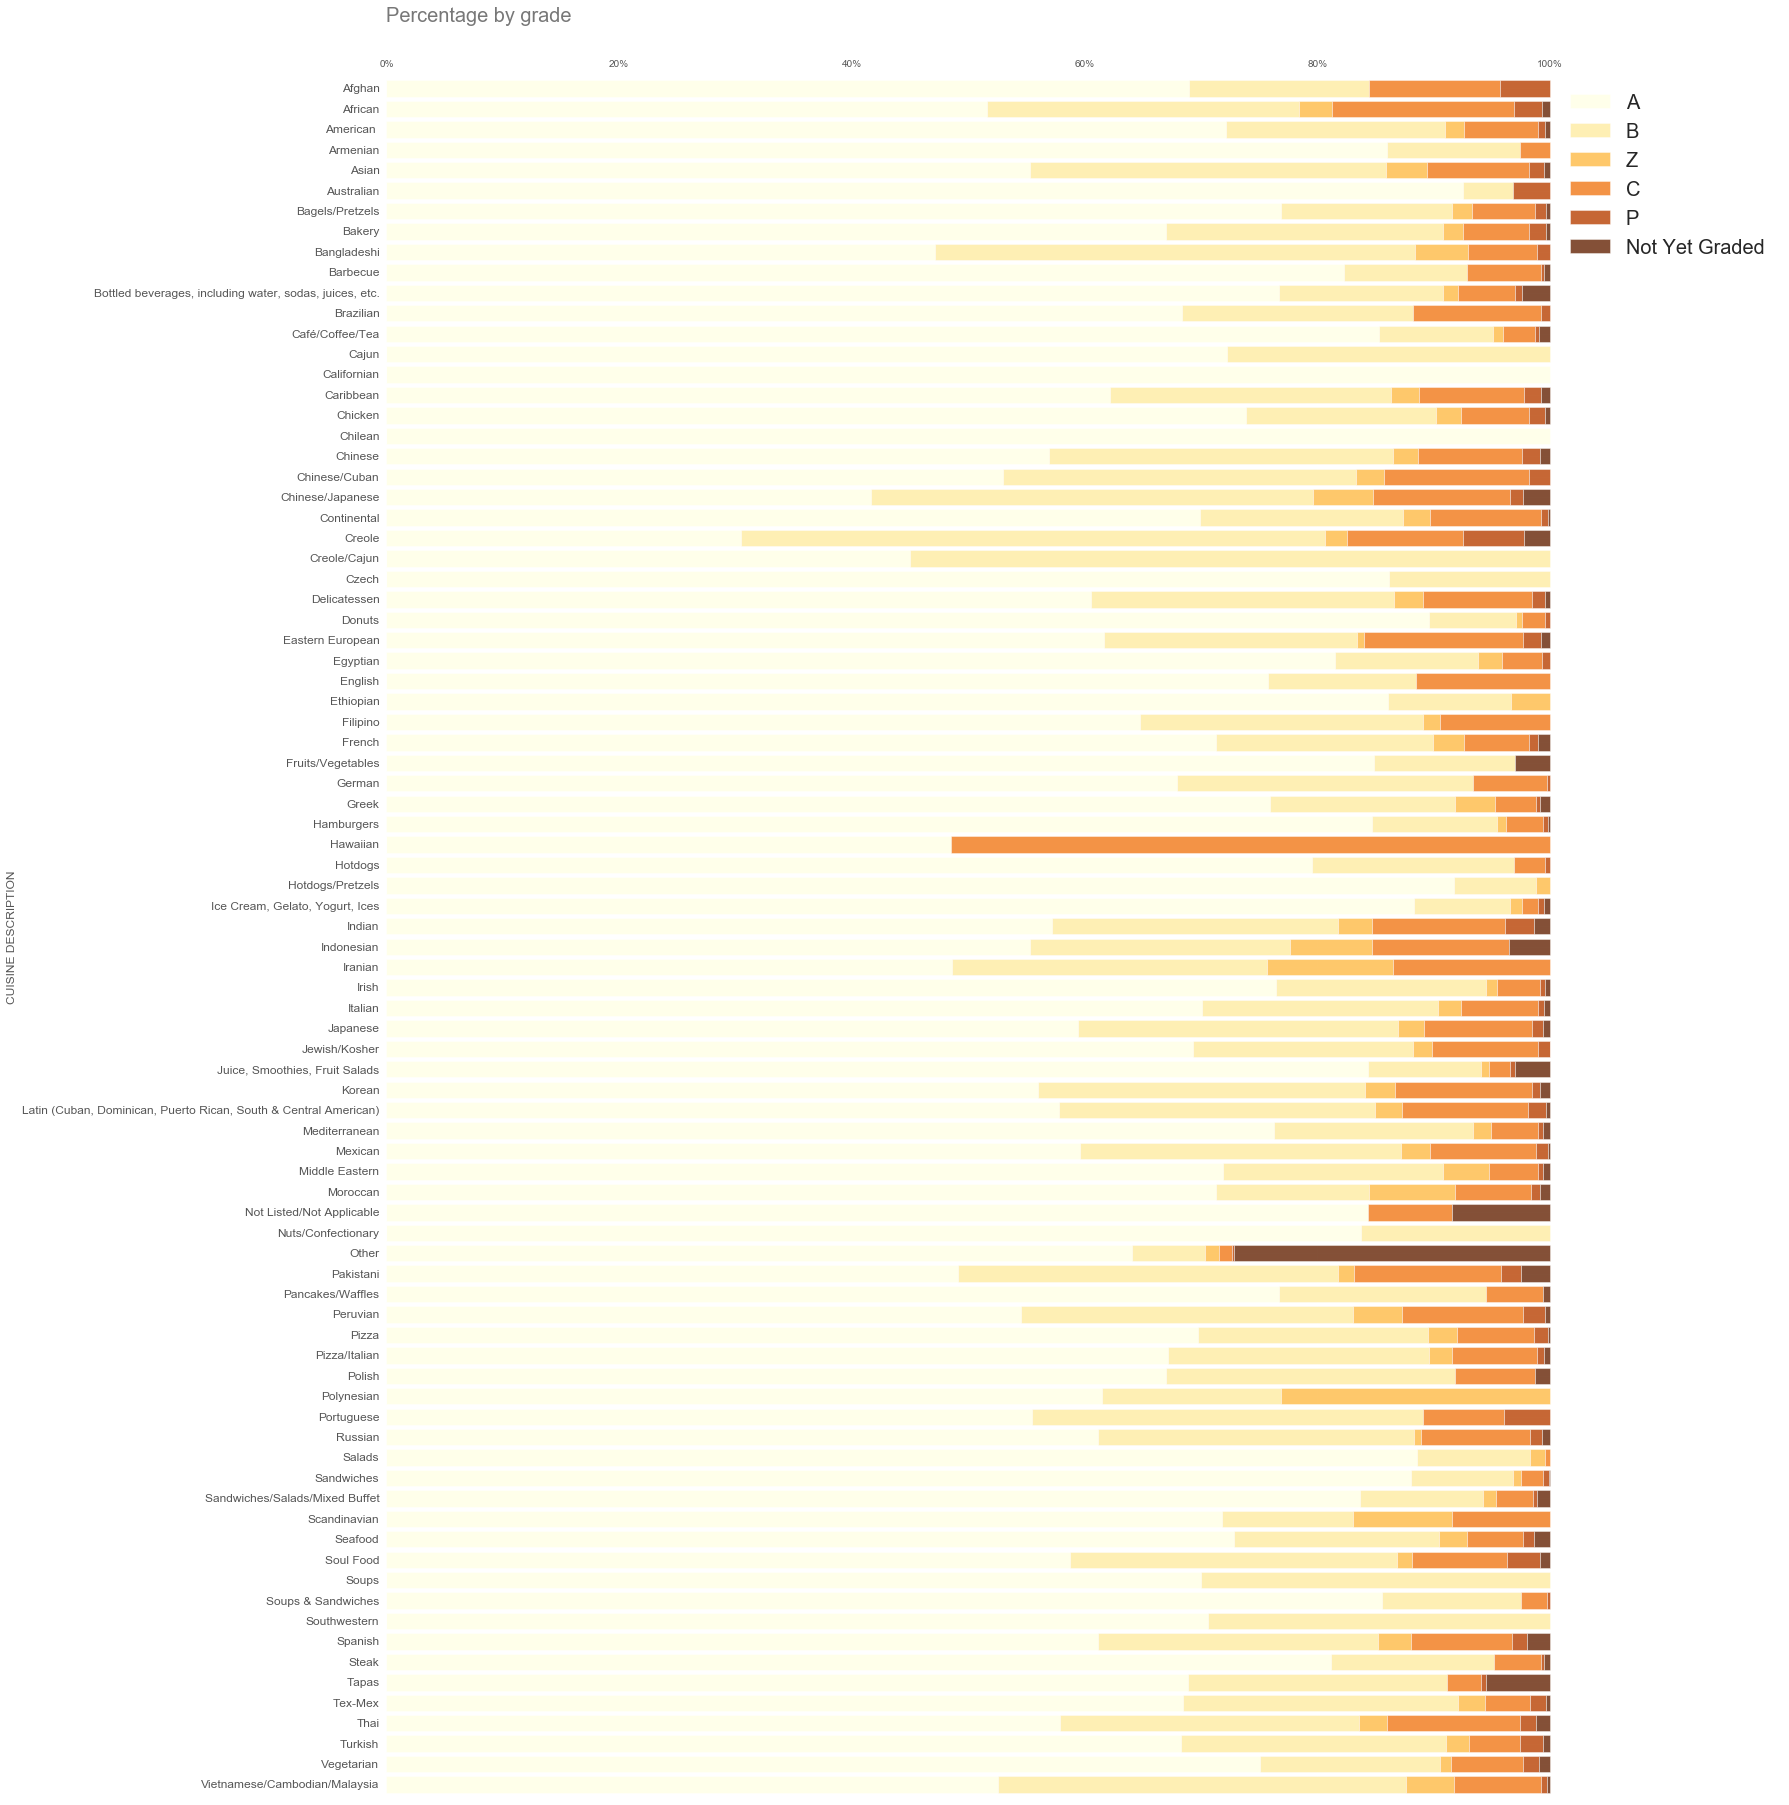

In [79]:
plot_stacked_bar(df_cuisine_grades_by_composition * 100, 'Percentage by grade')

In [19]:
def plot_dist(df_to_plot, series_name, lab):
    '''
    INPUT: DF, name of the column or series, label for the x-axis
    OUTPUT: distribution of violation codes sorted by popularity (Bar Chart)
    '''

    # create a figure of given size
    fig = plt.figure(figsize=(10,20))

    # add a subplot
    ax = fig.add_subplot(111)
    
    # set color transparency (0: transparent; 1: solid)
    a = 0.8

    # set x axis label on top of plot, set label text
    ax.xaxis.set_label_position('bottom')
    xlab = lab
    ax.set_xlabel(xlab, fontsize=20, alpha=a, ha='left')
    ax.xaxis.set_label_coords(0, 1.04)

    # position x tick labels on top
    ax.xaxis.tick_top()

    # remove tick lines in x and y axes
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')

    # remove grid lines (dotted lines inside plot)
    ax.grid(False)

    # remove plot frame
    ax.set_frame_on(False)

    # labeling 
    labels = df_to_plot[series_name].value_counts().index
    labels_cnv = [str(labels[i]) for i, acct in enumerate(labels)]

    # using the actual data to plot
    df_to_plot[series_name].value_counts()[::-1].plot(
    ax=ax, 
    kind='barh', 
    color=(0.9698, 0.6378, 0.3373), 
    alpha=a, 
    edgecolor='w',
    label=labels_cnv, 
    fontsize=12, 
    grid=True, 
    width=.8
    )

    # remove weird dotted line on axis
    ax.lines[0].set_visible(False)
    
    plt.tight_layout()
    plt.show();

## A distribution of violation code, to see which violations are most popular

* Sorted by popularity (or highest count)

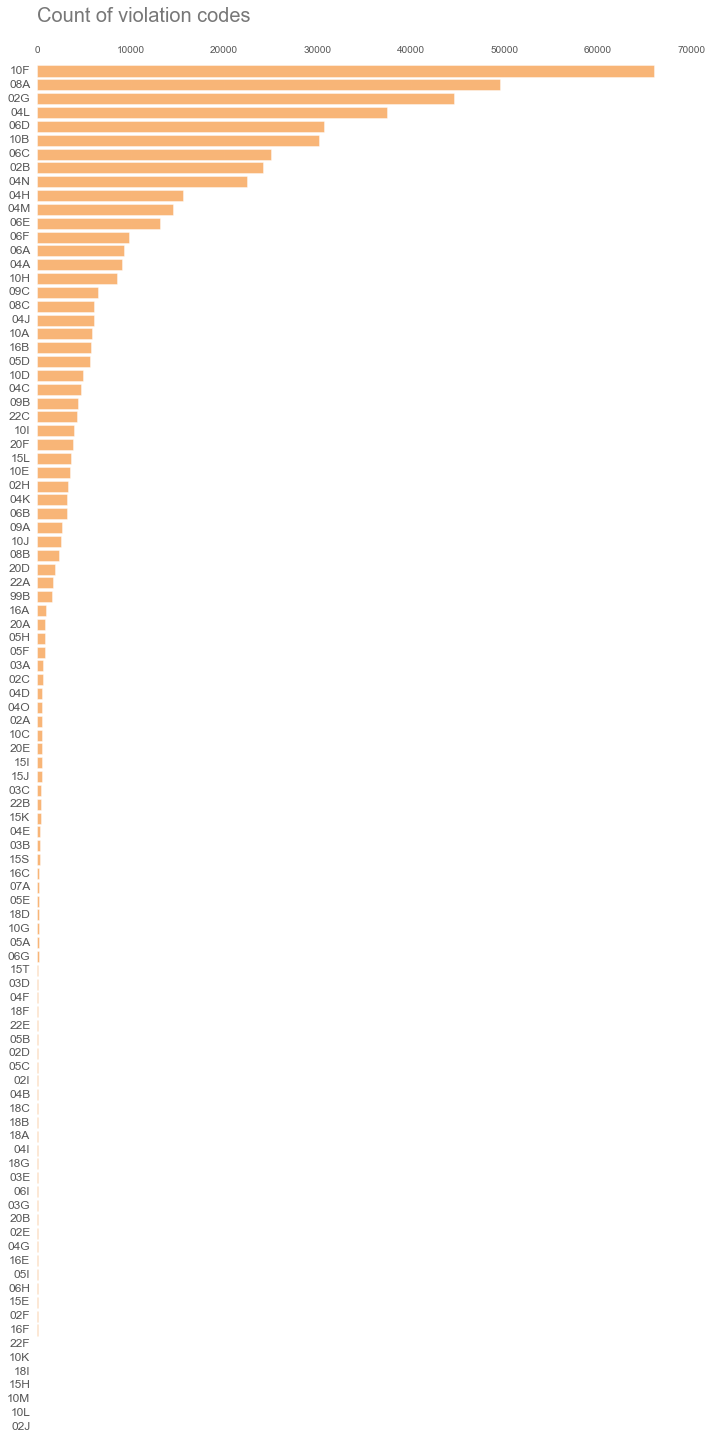

In [83]:
plot_dist(df, 'VIOLATION CODE', 'Count of violation codes')

In [84]:
def code_to_description_lookup(raw_df, violation_code_str):
    '''
    INPUT: raw df, violation code eg '10F' 
    OUTPUT: description (text), count of the code (int)
    
    Purpose: extra tool to look-up descriptions given the violation code
    '''
    df_dictionary_violation_code = raw_df[['VIOLATION CODE', 'VIOLATION DESCRIPTION']].groupby(['VIOLATION CODE', 'VIOLATION DESCRIPTION']).size()
    return df_dictionary_violation_code.ix[violation_code_str]

code_to_description_lookup(df, '10F')

VIOLATION DESCRIPTION
Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact surface or equipment improperly maintained and/or not properly sealed, raised, spaced or movable to allow accessibility for cleaning on all sides, above and underneath the unit.    66006
dtype: int64

In [86]:
def print_top_k_violation_codes(raw_df, k):
    '''
    INPUT: DF, top k eg top 5 violations codes; k = 5
    OUTPUT: None, prints to the screen (stdout)
    
    Purpose: Offer a ranked list of the violation codes with descriptions
    '''
    dfn = raw_df[['VIOLATION CODE', 'VIOLATION DESCRIPTION']].groupby(['VIOLATION CODE', 'VIOLATION DESCRIPTION']).agg(np.size)

    dfn.name = 'code'
    dfn.sort('code', ascending=False)    
    for rank, code_desc in enumerate(zip(dfn[:k].index ,dfn[:k])):
        
        # unpacking nested tuples
        code, desc = code_desc[0]
        
        print str(rank + 1) + ')'
        print code, code_desc[1]
        
        # formatting to match length of line
        print '-' * (len(code + str(code_desc[1])) + 1) 
        print desc
        print '=' * 65

print_top_k_violation_codes(df, 4)        

1)
10F 132012
----------
Non-food contact surface improperly constructed. Unacceptable material used. Non-food contact surface or equipment improperly maintained and/or not properly sealed, raised, spaced or movable to allow accessibility for cleaning on all sides, above and underneath the unit.
2)
08A 98962
---------
Facility not vermin proof. Harborage or conditions conducive to attracting vermin to the premises and/or allowing vermin to exist.
3)
02G 89148
---------
Cold food item held above 41º F (smoked fish and reduced oxygen packaged foods above 38 ºF) except during necessary preparation.
4)
04L 74908
---------
Evidence of mice or live mice present in facility's food and/or non-food areas.


#### Setting up Hypothesis Test: Chi-square goodness of fit

* The null states H<sub>0</sub>: there is no relationship between cuisine type and restaurant grade

_Assuming no relationship between cuisine and restaurant grade the following proportions should make sense regardless of cuisine_


In [26]:
df_proportions_with_ct = df_to_perc_breakouts_per_cuisine(df)[:]

# no need for nans
del df_proportions_with_ct['nan']

# Proportions -> observed counts per cuisine
for col in df_proportions_with_ct.columns.tolist():
    if col == 'GRADE': continue
    df_proportions_with_ct[col] *= df_proportions_with_ct['GRADE'] 

# Setting up H_0
total_distribution_proportion = {}
for col in df_proportions_with_ct.columns.tolist():
    if col == 'GRADE': continue
    total_distribution_proportion[col] = df_proportions_with_ct[col].sum() / df_proportions_with_ct['GRADE'].sum()

# Display proportions in table from of aggregate data
pd.DataFrame(total_distribution_proportion, index=[0])

,A,B,C,Not Yet Graded,P,Z
0,0.680488,0.212704,0.070549,0.007381,0.00944,0.019438


In [98]:
#used to randomly sample from our set of cuisines
random_observation_seed = np.random.randint(1, df_proportions_with_ct.shape[0] + 1)

# Generate expected frequencies
expected = {}
rand_obs = df_proportions_with_ct.ix[random_observation_seed,:].to_dict()
rand_obs_cuisine = df_proportions_with_ct.ix[random_observation_seed,:].name

for key, val in total_distribution_proportion.iteritems():
    expected[key] = rand_obs['GRADE'] * val

rand_obs.pop('GRADE')

df_expected = pd.DataFrame().from_dict(expected, orient='index')
df_expected.columns = ['Expected frequency']
display(df_expected)

print 

df_rand_obs = pd.DataFrame().from_dict(rand_obs, orient='index')
df_rand_obs.columns = ['Random observation frequency']
display(df_rand_obs)


# We can safely reject the H_0, this p-value is too extreme 
# to happen by random chance.
chi, p_val = stats.chisquare(rand_obs.values(), expected.values())

df_random_obs_stats = pd.DataFrame().from_dict({
    'p-value: ': p_val, 
    'random cuisine type:': rand_obs_cuisine, 
    'chi-squared test statistic:' : chi
}, orient='index')

df_random_obs_stats.columns = ['H Test Stats']
display(df_random_obs_stats)


,Expected frequency
A,39.468284
C,4.091831
B,12.336860
Not Yet Graded,0.428069
P,0.547548
Z,1.127408


,Random observation frequency
A,50
C,0
B,8
Not Yet Graded,0
P,0
Z,0


,H Test Stats
p-value:,0.0615444
random cuisine type:,Czech
chi-squared test statistic:,10.5297


### Is there a statistically significant relationship between type of cuisine and restaurant grade?
* With a critical region defined as **$\alpha $ = 0.01** i.e. 99% confidence interval, we can safely reject the H<sub>0</sub>: There is no relationship between cuisine type and restaurant grade. The alternative being **H<sub>A</sub>: There is a relationship between cuisine type and restaurant grade.**

### What test did we perform?
* $\chi^2$ Chi-Squared test: Goodness of fit. It's used to find the significance of association in two categorical variables. In our case these variables are cuisine type (Indian, American, ..) and restaurant grade (A, B, ..).

### What does this finding mean in this context?
* There is a statistically significant relationship between the type of cuisine and the grade the restaurant received. Given the p-value, **it is highly unlikely that a relationship between grade and cuisine type doesn't exist.**

### Based on findings, what recommendations would you give the DOHMH to prioritize inspections?
* At a glance, these findings might suggest some cuisine types are given an unfair advantage versus other types, hence recommending that a fair inspection be given to all restaurants regardless of the type of cuisine. Though, that may very well not be the case -- cleanliness of a restaurant has more to do with the management. Specifically, the management of particular cuisine type is likely the culprit. As a hypothetical example, maybe it is true that typically the restaurant management of Indian cuisines tend to be a bit more unkept, say versus American. **In which case DOHMH should focus efforts on improving restaurant environments of particular cuisine types that typically seem to be falling short.**


* On the other end, maybe an inspection favors certain cuisines merely by design. It's entirely possible that it was designed at a time where there wasn't such a diverse selection of cuisine types, hence our findings might be suggesting that **inspection methods need to be revised such that it's custom tailored (or tweaked) to the subject cuisine type.**


* Violation codes regarding vermin control seem to be among the more popular. This may be a potential low hanging solution for the DOHMH and it speaks more to the city as opposed to restaurant owners.


### Next step

_It may be prudent to look for inferences in the corpus of popular violation code descriptions. As an initial technique we could use a simple bag-of-words model to look at popular n-grams being used. We can also use a latent topic modeler to look potential latent topics within the descriptions._
